# Assignment 3 - [student name]_[student ID]

It is your turn to design the structure of the work.


In [1]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import json 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
# Load metadata
train = os.path.join("train")
classes = os.listdir(train)
print(f"Classes: {classes}")
# Count images per class
class_count = {}
for c in classes:
    class_count[c] = len(os.listdir(os.path.join(train, c)))
print(f"Class distribution: {class_count}")

Classes: ['ig', 'erythroblast', 'neutrophil', 'lymphocyte', 'basophil', 'monocyte', 'platelet', 'eosinophil']
Class distribution: {'ig': 400, 'erythroblast': 400, 'neutrophil': 400, 'lymphocyte': 400, 'basophil': 400, 'monocyte': 400, 'platelet': 400, 'eosinophil': 400}


In [3]:
bad_images = []   # store any black/white images

for cls in os.listdir(train):
    class_path = os.path.join(train, cls)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            img = Image.open(img_path).convert("L") 
            arr = np.array(img)

            # Check if image is all black or all white
            if arr.max() == 255 and arr.min() == 255:
                bad_images.append((img_path, "white"))
            elif arr.max() == 0 and arr.min() == 0:
                bad_images.append((img_path, "black"))

        except Exception as e:
            bad_images.append((img_path, f"error: {e}"))

print("Bad images:", bad_images)

Bad images: []


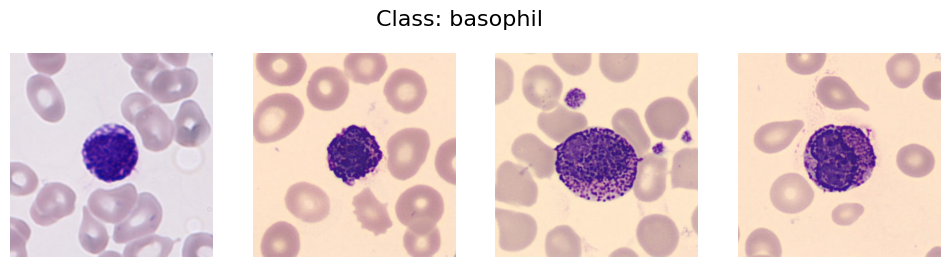

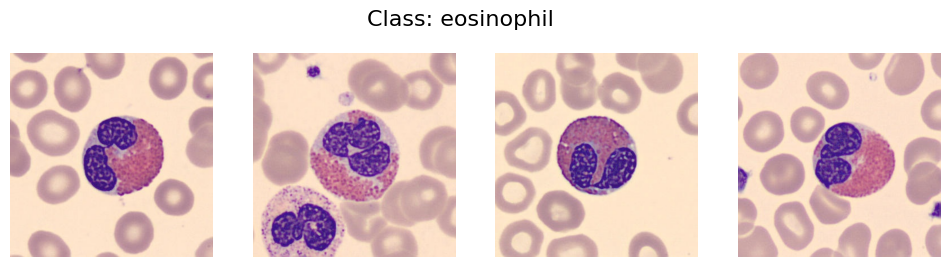

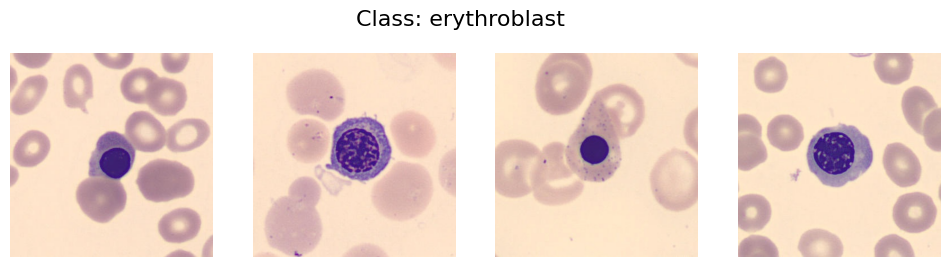

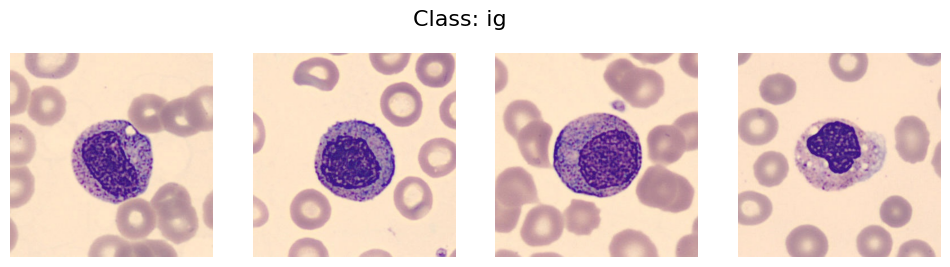

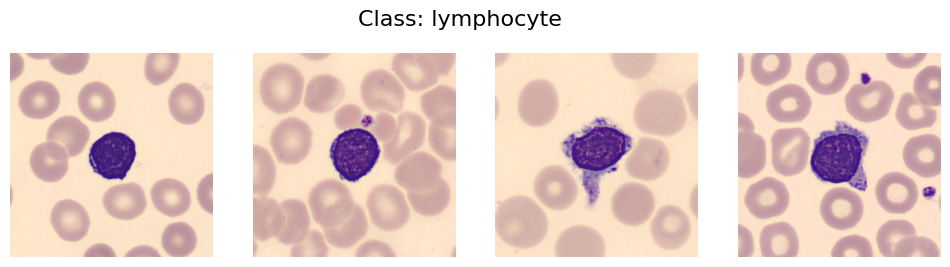

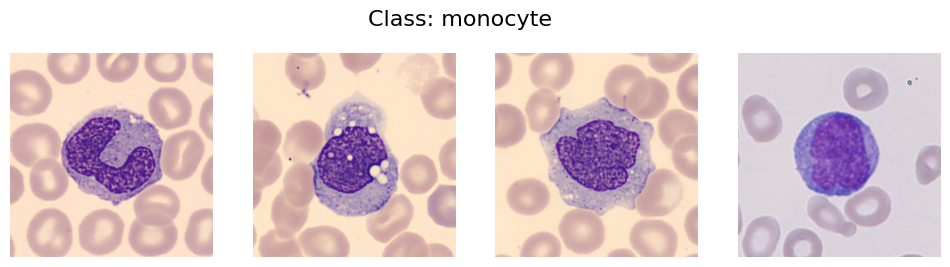

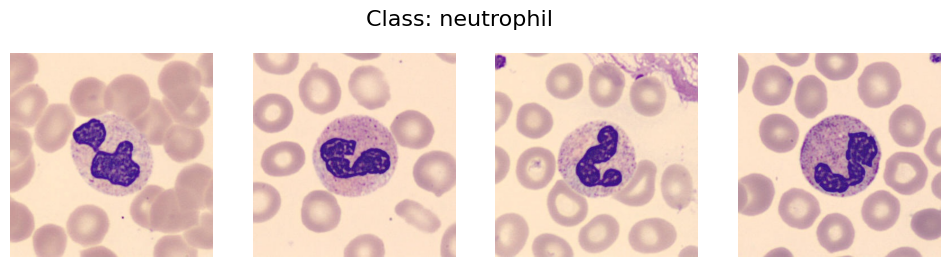

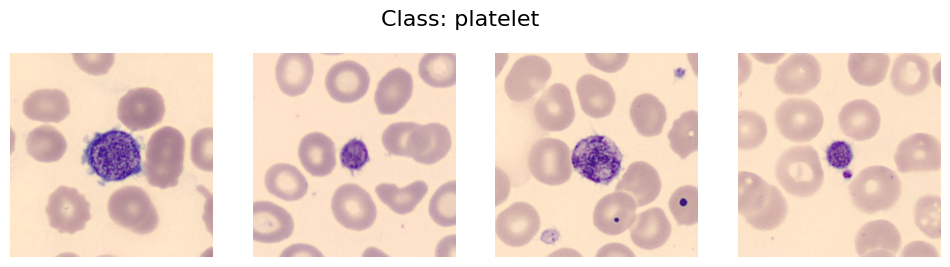

In [4]:
# Visualize some sample images from each class

train = "train"
num_samples = 4   # 4 images per class

classes = sorted(os.listdir(train))

for cls in classes:
    class_path = os.path.join(train, cls)
    images = os.listdir(class_path)[:num_samples]  # take first 4 images

    plt.figure(figsize=(12, 3))
    plt.suptitle(f"Class: {cls}", fontsize=16)

    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()

In [5]:
# Create a DataFrame with image paths and labels
def class_label_map(class_name):
    with open("class_map.json", "r") as f:
        class_map = json.load(f)
    return class_map.get(class_name, -1)

def create_dataframe(data_dir):
    data = []
    classes = sorted(os.listdir(data_dir))

    for cls in classes:
        class_path = os.path.join(data_dir, cls)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            class_label = class_label_map(cls)
            data.append({"image_path": img_path, "label": class_label})

    df = pd.DataFrame(data)
    return df


train_df = create_dataframe("train")
train_df.head()

,image_path,label
0,train/basophil/BA_447906.jpg,0
1,train/basophil/BA_692284.jpg,0
2,train/basophil/BA_513500.jpg,0
3,train/basophil/BA_45632.jpg,0
4,train/basophil/BA_879692.jpg,0


In [6]:
# Split dataset into train, validation, and test sets
def split_dataset(dataframe, test_ratio=0.2, validation_ratio=0.2):
    train_df = dataframe.sample(frac=1, random_state=42).reset_index(drop=True) 

    train_split_idx = int(len(train_df) * (1 - test_ratio))
    train_set = train_df.iloc[:train_split_idx].reset_index(drop=True)
    test_set = train_df.iloc[train_split_idx:].reset_index(drop=True)

    val_split_idx = int(len(train_set) * (1 - validation_ratio))

    val_set = train_set.iloc[val_split_idx:].reset_index(drop=True)
    train_set = train_set.iloc[:val_split_idx].reset_index(drop=True)

    return train_set, val_set, test_set

train_set, val_set, test_set = split_dataset(train_df)
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 2048
Validation set size: 512
Test set size: 640


In [7]:
# Augmentation and Preprocessing using torchvision v2
import torch
import torchvision.transforms as T

In [8]:
# Data augmentation example
train_transforms = T.Compose([
    T.RandomResizedCrop(size=(224, 224), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor()
    
])  
val_transforms = T.Compose([
    T.Resize(size=(256, 256), antialias=True),
    T.ToTensor()
])

In [9]:
# Custom Dataset class
class CellImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]["image_path"]
        label = self.dataframe.iloc[idx]["label"]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
    
train_dataset = CellImageDataset(train_set, transform=train_transforms)
val_dataset = CellImageDataset(val_set, transform=val_transforms)
test_dataset = CellImageDataset(test_set, transform=val_transforms)

In [10]:
# data loaders

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [11]:
# DenseNet Implementation from Scratch

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class TinyResNet(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.layer1 = BasicBlock(3, 32)
        self.layer2 = BasicBlock(32, 64, stride=2)
        self.layer3 = BasicBlock(64, 128, stride=2)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x



In [12]:
# Initialize model, loss function, optimizer, and training loop
denseNetModel = TinyResNet(num_classes=8)

def train_model(model, train_loader, val_loader, epochs=50, lr=1e-4, device="cuda"):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\n===== Epoch {epoch+1}/{epochs} =====")

        # TRAINING

        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)

        # VALIDATION

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating", leave=False):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        avg_val_loss = val_loss / len(val_loader)

    
        # Print stats

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc:.2f}%")


        # Save Best Model

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_densenet121.pth")
            print(f" Saved new best model with accuracy: {val_acc:.2f}%")

    print("\nTraining complete!")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")



train_model(denseNetModel, train_loader, val_loader, epochs=50, lr=1e-4, device="cuda")


===== Epoch 1/50 =====


Train Loss: 1.7347 | Train Acc: 47.80%
Val Loss:   1.8037 | Val Acc:   33.20%
 Saved new best model with accuracy: 33.20%

===== Epoch 2/50 =====


Train Loss: 1.4348 | Train Acc: 65.19%
Val Loss:   1.5695 | Val Acc:   63.67%
 Saved new best model with accuracy: 63.67%

===== Epoch 3/50 =====


Train Loss: 1.2750 | Train Acc: 73.29%
Val Loss:   1.4942 | Val Acc:   62.11%

===== Epoch 4/50 =====


Train Loss: 1.1610 | Train Acc: 76.27%
Val Loss:   1.3989 | Val Acc:   62.11%

===== Epoch 5/50 =====


Train Loss: 1.0510 | Train Acc: 78.47%
Val Loss:   1.3083 | Val Acc:   71.09%
 Saved new best model with accuracy: 71.09%

===== Epoch 6/50 =====


Train Loss: 0.9793 | Train Acc: 80.27%
Val Loss:   1.2338 | Val Acc:   73.05%
 Saved new best model with accuracy: 73.05%

===== Epoch 7/50 =====


Train Loss: 0.9177 | Train Acc: 80.96%
Val Loss:   1.5371 | Val Acc:   46.88%

===== Epoch 8/50 =====


Train Loss: 0.8706 | Train Acc: 82.57%
Val Loss:   1.0795 | Val Acc:   80.27%
 Saved new best model with accuracy: 80.27%

===== Epoch 9/50 =====


Train Loss: 0.8078 | Train Acc: 83.20%
Val Loss:   1.1096 | Val Acc:   68.95%

===== Epoch 10/50 =====


Train Loss: 0.7828 | Train Acc: 82.76%
Val Loss:   1.1094 | Val Acc:   79.10%

===== Epoch 11/50 =====


Train Loss: 0.7637 | Train Acc: 83.94%
Val Loss:   1.0037 | Val Acc:   78.91%

===== Epoch 12/50 =====


Train Loss: 0.7111 | Train Acc: 85.60%
Val Loss:   0.9203 | Val Acc:   84.96%
 Saved new best model with accuracy: 84.96%

===== Epoch 13/50 =====


Train Loss: 0.6944 | Train Acc: 85.16%
Val Loss:   0.9226 | Val Acc:   82.23%

===== Epoch 14/50 =====


Train Loss: 0.6617 | Train Acc: 85.64%
Val Loss:   1.2495 | Val Acc:   55.47%

===== Epoch 15/50 =====


Train Loss: 0.6422 | Train Acc: 85.89%
Val Loss:   0.7785 | Val Acc:   85.16%
 Saved new best model with accuracy: 85.16%

===== Epoch 16/50 =====


Train Loss: 0.6290 | Train Acc: 85.94%
Val Loss:   0.8145 | Val Acc:   80.86%

===== Epoch 17/50 =====


Train Loss: 0.6104 | Train Acc: 85.40%
Val Loss:   0.7634 | Val Acc:   84.96%

===== Epoch 18/50 =====


Train Loss: 0.5915 | Train Acc: 87.11%
Val Loss:   0.8102 | Val Acc:   77.34%

===== Epoch 19/50 =====


Train Loss: 0.5559 | Train Acc: 87.70%
Val Loss:   0.6934 | Val Acc:   87.11%
 Saved new best model with accuracy: 87.11%

===== Epoch 20/50 =====


Train Loss: 0.5620 | Train Acc: 86.62%
Val Loss:   0.7678 | Val Acc:   83.20%

===== Epoch 21/50 =====


Train Loss: 0.5273 | Train Acc: 87.99%
Val Loss:   0.6889 | Val Acc:   86.91%

===== Epoch 22/50 =====


Train Loss: 0.5170 | Train Acc: 88.13%
Val Loss:   0.7697 | Val Acc:   79.30%

===== Epoch 23/50 =====


Train Loss: 0.5054 | Train Acc: 88.13%
Val Loss:   0.6552 | Val Acc:   85.74%

===== Epoch 24/50 =====


Train Loss: 0.4993 | Train Acc: 87.94%
Val Loss:   0.6681 | Val Acc:   85.74%

===== Epoch 25/50 =====


Train Loss: 0.5148 | Train Acc: 87.30%
Val Loss:   0.6636 | Val Acc:   85.55%

===== Epoch 26/50 =====


Train Loss: 0.4771 | Train Acc: 88.82%
Val Loss:   0.6048 | Val Acc:   87.89%
 Saved new best model with accuracy: 87.89%

===== Epoch 27/50 =====


Train Loss: 0.4645 | Train Acc: 88.96%
Val Loss:   0.6192 | Val Acc:   86.13%

===== Epoch 28/50 =====


Train Loss: 0.4542 | Train Acc: 89.06%
Val Loss:   0.6427 | Val Acc:   83.98%

===== Epoch 29/50 =====


Train Loss: 0.4514 | Train Acc: 88.43%
Val Loss:   0.5804 | Val Acc:   85.74%

===== Epoch 30/50 =====


Train Loss: 0.4622 | Train Acc: 88.09%
Val Loss:   0.7590 | Val Acc:   75.59%

===== Epoch 31/50 =====


Train Loss: 0.4401 | Train Acc: 89.36%
Val Loss:   0.6114 | Val Acc:   85.16%

===== Epoch 32/50 =====


Train Loss: 0.4413 | Train Acc: 89.40%
Val Loss:   0.5463 | Val Acc:   89.06%
 Saved new best model with accuracy: 89.06%

===== Epoch 33/50 =====


Train Loss: 0.4191 | Train Acc: 89.45%
Val Loss:   1.3052 | Val Acc:   60.74%

===== Epoch 34/50 =====


Train Loss: 0.4329 | Train Acc: 89.21%
Val Loss:   1.6240 | Val Acc:   59.96%

===== Epoch 35/50 =====


Train Loss: 0.4104 | Train Acc: 90.19%
Val Loss:   0.5825 | Val Acc:   85.74%

===== Epoch 36/50 =====


Train Loss: 0.4193 | Train Acc: 89.40%
Val Loss:   0.6054 | Val Acc:   84.57%

===== Epoch 37/50 =====


Train Loss: 0.4131 | Train Acc: 89.50%
Val Loss:   0.5750 | Val Acc:   85.74%

===== Epoch 38/50 =====


Train Loss: 0.4095 | Train Acc: 88.38%
Val Loss:   0.7112 | Val Acc:   75.39%

===== Epoch 39/50 =====


Train Loss: 0.4202 | Train Acc: 89.65%
Val Loss:   0.4949 | Val Acc:   89.65%
 Saved new best model with accuracy: 89.65%

===== Epoch 40/50 =====


Train Loss: 0.4097 | Train Acc: 89.11%
Val Loss:   0.5631 | Val Acc:   86.91%

===== Epoch 41/50 =====


Train Loss: 0.3728 | Train Acc: 90.38%
Val Loss:   0.5209 | Val Acc:   86.91%

===== Epoch 42/50 =====


Train Loss: 0.3767 | Train Acc: 90.48%
Val Loss:   0.4830 | Val Acc:   90.82%
 Saved new best model with accuracy: 90.82%

===== Epoch 43/50 =====


Train Loss: 0.3761 | Train Acc: 89.79%
Val Loss:   0.6131 | Val Acc:   80.66%

===== Epoch 44/50 =====


Train Loss: 0.3761 | Train Acc: 90.38%
Val Loss:   0.4420 | Val Acc:   90.23%

===== Epoch 45/50 =====


Train Loss: 0.3653 | Train Acc: 90.43%
Val Loss:   0.4168 | Val Acc:   91.41%
 Saved new best model with accuracy: 91.41%

===== Epoch 46/50 =====


Train Loss: 0.3467 | Train Acc: 91.16%
Val Loss:   0.5137 | Val Acc:   85.35%

===== Epoch 47/50 =====


Train Loss: 0.3576 | Train Acc: 90.87%
Val Loss:   0.4667 | Val Acc:   87.70%

===== Epoch 48/50 =====


Train Loss: 0.3509 | Train Acc: 90.33%
Val Loss:   2.5232 | Val Acc:   46.68%

===== Epoch 49/50 =====


Train Loss: 0.3345 | Train Acc: 91.16%
Val Loss:   1.7234 | Val Acc:   53.71%

===== Epoch 50/50 =====


Train Loss: 0.3307 | Train Acc: 92.33%
Val Loss:   0.4736 | Val Acc:   88.28%

Training complete!
Best Validation Accuracy: 91.41%


In [13]:

# 1. Dense Layer (BN → ReLU → 1×1 conv → BN → ReLU → 3×3 conv)
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size=4):
        super().__init__()
        
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu1(self.bn1(x)))
        out = self.conv2(self.relu2(self.bn2(out)))
        return torch.cat([x, out], dim=1)   # Dense connection



# 2. Dense Block (multiple dense layers)

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, bn_size=4):
        super().__init__()
        
        layers = []
        for i in range(num_layers):
            layers.append(DenseLayer(
                in_channels + i * growth_rate,
                growth_rate,
                bn_size
            ))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)



# 3. Transition Layer (compression)

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(self.relu(self.bn(x)))
        x = self.pool(x)
        return x



# 4. Full DenseNet Architecture (Configurable)

class DenseNet(nn.Module):
    def __init__(self, block_config, growth_rate=32, num_classes=8, bn_size=4):
        super().__init__()
        
        # Initial convolution
        num_init_features = 64
        
        self.conv0 = nn.Conv2d(3, num_init_features, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn0 = nn.BatchNorm2d(num_init_features)
        self.relu0 = nn.ReLU(inplace=True)
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Build Dense Blocks
        num_channels = num_init_features
        self.blocks = nn.ModuleList()
        self.transitions = nn.ModuleList()
        
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                in_channels=num_channels,
                growth_rate=growth_rate,
                bn_size=bn_size
            )
            self.blocks.append(block)
            num_channels = num_channels + num_layers * growth_rate
            
            # Add transition layer except after last block
            if i != len(block_config) - 1:
                out_channels = num_channels // 2
                trans = TransitionLayer(num_channels, out_channels)
                self.transitions.append(trans)
                num_channels = out_channels
        
        # Final batch norm
        self.bn_final = nn.BatchNorm2d(num_channels)
        
        # Classification layer
        self.fc = nn.Linear(num_channels, num_classes)
    
    def forward(self, x):
        x = self.pool0(self.relu0(self.bn0(self.conv0(x))))
        
        # Dense blocks + transitions
        for i, block in enumerate(self.blocks):
            x = block(x)
            if i < len(self.transitions):
                x = self.transitions[i](x)
        
        x = F.relu(self.bn_final(x))
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



# 5. Create DenseNet-121

def densenet121(num_classes=8):
    # DenseNet-121 block config from the paper:
    # 121 = (6 + 12 + 24 + 16) layers + transition + others
    return DenseNet(block_config=[6, 12, 24, 16],
                    growth_rate=32,
                    num_classes=num_classes)

largeModel = densenet121()
train_model(largeModel, train_loader, val_loader, epochs=50, lr=1e-4, device="cuda")


===== Epoch 1/50 =====


Training:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 1.1661 | Train Acc: 63.48%
Val Loss:   1.2674 | Val Acc:   57.81%
 Saved new best model with accuracy: 57.81%

===== Epoch 2/50 =====


Train Loss: 0.6609 | Train Acc: 79.64%
Val Loss:   0.6491 | Val Acc:   80.86%
 Saved new best model with accuracy: 80.86%

===== Epoch 3/50 =====


Train Loss: 0.5719 | Train Acc: 82.18%
Val Loss:   0.5729 | Val Acc:   79.49%

===== Epoch 4/50 =====


Train Loss: 0.5186 | Train Acc: 83.50%
Val Loss:   0.5869 | Val Acc:   80.27%

===== Epoch 5/50 =====


Train Loss: 0.4123 | Train Acc: 87.79%
Val Loss:   0.4611 | Val Acc:   83.20%
 Saved new best model with accuracy: 83.20%

===== Epoch 6/50 =====


Train Loss: 0.4294 | Train Acc: 86.72%
Val Loss:   0.3113 | Val Acc:   90.62%
 Saved new best model with accuracy: 90.62%

===== Epoch 7/50 =====


Train Loss: 0.4054 | Train Acc: 87.70%
Val Loss:   0.5990 | Val Acc:   79.49%

===== Epoch 8/50 =====


Train Loss: 0.3847 | Train Acc: 88.43%
Val Loss:   2.0124 | Val Acc:   55.47%

===== Epoch 9/50 =====


Train Loss: 0.3919 | Train Acc: 87.89%
Val Loss:   0.5792 | Val Acc:   79.30%

===== Epoch 10/50 =====


Train Loss: 0.3262 | Train Acc: 90.04%
Val Loss:   0.2974 | Val Acc:   90.23%

===== Epoch 11/50 =====


Train Loss: 0.3247 | Train Acc: 89.65%
Val Loss:   0.2456 | Val Acc:   91.80%
 Saved new best model with accuracy: 91.80%

===== Epoch 12/50 =====


Train Loss: 0.2885 | Train Acc: 90.67%
Val Loss:   0.2761 | Val Acc:   92.97%
 Saved new best model with accuracy: 92.97%

===== Epoch 13/50 =====


Train Loss: 0.2924 | Train Acc: 90.92%
Val Loss:   1.2272 | Val Acc:   68.95%

===== Epoch 14/50 =====


Train Loss: 0.2898 | Train Acc: 90.62%
Val Loss:   1.2312 | Val Acc:   58.40%

===== Epoch 15/50 =====


Train Loss: 0.2884 | Train Acc: 90.87%
Val Loss:   0.8336 | Val Acc:   79.49%

===== Epoch 16/50 =====


Train Loss: 0.2670 | Train Acc: 91.06%
Val Loss:   0.4331 | Val Acc:   84.18%

===== Epoch 17/50 =====


Train Loss: 0.2583 | Train Acc: 91.85%
Val Loss:   0.2321 | Val Acc:   91.41%

===== Epoch 18/50 =====


Train Loss: 0.2275 | Train Acc: 92.77%
Val Loss:   0.3277 | Val Acc:   87.50%

===== Epoch 19/50 =====


Train Loss: 0.2278 | Train Acc: 92.19%
Val Loss:   0.2416 | Val Acc:   93.16%
 Saved new best model with accuracy: 93.16%

===== Epoch 20/50 =====


Train Loss: 0.2493 | Train Acc: 92.14%
Val Loss:   0.1898 | Val Acc:   94.53%
 Saved new best model with accuracy: 94.53%

===== Epoch 21/50 =====


Train Loss: 0.2167 | Train Acc: 93.07%
Val Loss:   0.3649 | Val Acc:   87.50%

===== Epoch 22/50 =====


Train Loss: 0.2131 | Train Acc: 93.65%
Val Loss:   0.2530 | Val Acc:   91.80%

===== Epoch 23/50 =====


Train Loss: 0.2178 | Train Acc: 93.12%
Val Loss:   0.3679 | Val Acc:   89.06%

===== Epoch 24/50 =====


Train Loss: 0.2425 | Train Acc: 91.46%
Val Loss:   2.7859 | Val Acc:   49.02%

===== Epoch 25/50 =====


Train Loss: 0.2107 | Train Acc: 93.02%
Val Loss:   0.3065 | Val Acc:   90.43%

===== Epoch 26/50 =====


Train Loss: 0.2017 | Train Acc: 93.75%
Val Loss:   0.1531 | Val Acc:   95.70%
 Saved new best model with accuracy: 95.70%

===== Epoch 27/50 =====


Train Loss: 0.2242 | Train Acc: 92.53%
Val Loss:   0.2325 | Val Acc:   93.16%

===== Epoch 28/50 =====


Train Loss: 0.1759 | Train Acc: 94.53%
Val Loss:   0.3320 | Val Acc:   88.67%

===== Epoch 29/50 =====


Train Loss: 0.1946 | Train Acc: 93.75%
Val Loss:   0.1838 | Val Acc:   93.75%

===== Epoch 30/50 =====


Train Loss: 0.2255 | Train Acc: 92.29%
Val Loss:   0.3686 | Val Acc:   88.28%

===== Epoch 31/50 =====


Train Loss: 0.1863 | Train Acc: 93.99%
Val Loss:   0.1371 | Val Acc:   96.09%
 Saved new best model with accuracy: 96.09%

===== Epoch 32/50 =====


Train Loss: 0.1876 | Train Acc: 93.95%
Val Loss:   1.8158 | Val Acc:   63.67%

===== Epoch 33/50 =====


Train Loss: 0.1987 | Train Acc: 93.36%
Val Loss:   0.3211 | Val Acc:   87.50%

===== Epoch 34/50 =====


Train Loss: 0.1789 | Train Acc: 94.24%
Val Loss:   0.1655 | Val Acc:   95.12%

===== Epoch 35/50 =====


Train Loss: 0.1865 | Train Acc: 93.60%
Val Loss:   0.3114 | Val Acc:   89.06%

===== Epoch 36/50 =====


Train Loss: 0.1955 | Train Acc: 93.60%
Val Loss:   0.3099 | Val Acc:   88.28%

===== Epoch 37/50 =====


Train Loss: 0.1826 | Train Acc: 94.09%
Val Loss:   0.1255 | Val Acc:   97.27%
 Saved new best model with accuracy: 97.27%

===== Epoch 38/50 =====


Train Loss: 0.1854 | Train Acc: 93.41%
Val Loss:   0.2083 | Val Acc:   93.55%

===== Epoch 39/50 =====


Train Loss: 0.1901 | Train Acc: 94.04%
Val Loss:   2.6233 | Val Acc:   51.17%

===== Epoch 40/50 =====


Train Loss: 0.2064 | Train Acc: 92.68%
Val Loss:   0.2653 | Val Acc:   91.60%

===== Epoch 41/50 =====


Train Loss: 0.1765 | Train Acc: 93.70%
Val Loss:   0.1497 | Val Acc:   95.70%

===== Epoch 42/50 =====


Train Loss: 0.1567 | Train Acc: 94.73%
Val Loss:   0.3031 | Val Acc:   88.87%

===== Epoch 43/50 =====


Train Loss: 0.1667 | Train Acc: 94.14%
Val Loss:   0.2973 | Val Acc:   89.26%

===== Epoch 44/50 =====


Train Loss: 0.1806 | Train Acc: 94.34%
Val Loss:   0.4255 | Val Acc:   85.16%

===== Epoch 45/50 =====


Train Loss: 0.1535 | Train Acc: 94.82%
Val Loss:   0.1959 | Val Acc:   93.36%

===== Epoch 46/50 =====


Train Loss: 0.1864 | Train Acc: 93.70%
Val Loss:   0.1491 | Val Acc:   95.70%

===== Epoch 47/50 =====


Train Loss: 0.1591 | Train Acc: 94.87%
Val Loss:   0.6212 | Val Acc:   77.54%

===== Epoch 48/50 =====


Train Loss: 0.1723 | Train Acc: 93.85%
Val Loss:   0.2040 | Val Acc:   93.36%

===== Epoch 49/50 =====


Train Loss: 0.1544 | Train Acc: 94.63%
Val Loss:   0.6807 | Val Acc:   75.39%

===== Epoch 50/50 =====


Train Loss: 0.1386 | Train Acc: 95.61%
Val Loss:   0.3156 | Val Acc:   88.09%

Training complete!
Best Validation Accuracy: 97.27%


In [14]:
# Test unknown images
def test_unknown_images(model, test_directory, transform, device="cuda"):
    model.to(device)
    model.eval()
    predictions = []
    image_paths = [os.path.join(test_directory, img) for img in os.listdir(test_directory)]
    with torch.no_grad():
        for img_path in image_paths:
            image = Image.open(img_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)  # add batch dimension

            output = model(image)
            _, predicted = output.max(1)
            predictions.append(predicted.item())
    return predictions

large_model_result = test_unknown_images(largeModel, "test", val_transforms)
tiny_model_result = test_unknown_images(denseNetModel, "test", val_transforms)




In [15]:
print(large_model_result)
print("**********")
print(tiny_model_result)

[1, 6, 2, 5, 4, 3, 7, 4, 0, 3, 6, 3, 0, 5, 3, 1, 7, 6, 2, 3, 1, 0, 0, 7, 6, 3, 2, 1, 5, 0, 6, 3, 1, 3, 4, 7, 2, 3, 1, 2, 1, 6, 7, 0, 2, 3, 3, 1, 7, 3, 2, 7, 0, 2, 1, 7, 7, 7, 7, 0, 1, 6, 6, 2, 6, 5, 0, 1, 2, 7, 3, 1, 7, 1, 6, 3, 7, 4, 2, 2, 3, 1, 5, 4, 5, 2, 7, 3, 6, 1, 0, 3, 2, 4, 5, 5, 7, 5, 3, 3, 7, 4, 2, 1, 3, 2, 5, 2, 7, 0, 3, 6, 3, 0, 6, 4, 2, 0, 2, 1, 0, 1, 3, 7, 3, 1, 3, 5, 4, 6, 0, 3, 1, 2, 7, 4, 3, 0, 7, 6, 5, 0, 4, 7, 0, 6, 6, 2, 4, 0, 6, 1, 4, 1, 7, 0, 6, 7, 2, 1, 2, 5, 1, 5, 1, 3, 6, 6, 1, 3, 0, 4, 4, 6, 2, 7, 2, 2, 3, 5, 3, 4, 0, 3, 0, 7, 4, 6, 4, 4, 4, 0, 0, 2, 3, 6, 7, 3, 2, 3, 1, 4, 7, 1, 4, 4, 7, 5, 0, 6, 2, 3, 6, 0, 6, 7, 6, 5, 3, 2, 3, 5, 6, 0, 6, 0, 4, 1, 0, 0, 7, 7, 3, 3, 0, 4, 7, 0, 3, 4, 7, 6, 3, 4, 1, 2, 4, 3, 6, 6, 5, 1, 4, 2, 7, 3, 3, 2, 7, 4, 5, 1, 3, 7, 0, 6, 6, 6, 4, 7, 7, 2, 5, 4, 2, 2, 1, 7, 3, 1, 0, 3, 0, 2, 2, 3, 2, 3, 4, 6, 1, 5, 7, 3, 2, 0, 0, 7, 7, 4, 5, 0, 5, 4, 4, 7, 3, 2, 6, 7, 4, 6, 4, 7, 0, 2, 5, 0, 1, 5, 3, 4, 0, 2, 3, 1, 1, 3, 2, 2, 1, 1, 6, 